#classical_models

In [1]:
#!git clone https://github.com/leonardoLavagna/qaoa

In [2]:
import pickle
import os
os.chdir("qaoa")

In [3]:
#!pip install -r requirements.txt
#!pip install torch_geometric

In [4]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.utils import from_networkx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from config import *

In [5]:
class MaxCutMLP(nn.Module):
    def __init__(self, input_size, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)


class MaxCutGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=2, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * 2, hidden_dim, heads=1, concat=False, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.gat1(data.x, data.edge_index))
        x = F.relu(self.gat2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.sage1(data.x, data.edge_index))
        x = F.relu(self.sage2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGIN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        mlp1 = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        mlp2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)
    

class MaxCutLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(-1) 
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(-1)

In [6]:
def train_vec(model, X_train, y_train, X_test, y_test, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train).squeeze()
        loss = loss_fn(out, y_train.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"[MLP] Epoch {epoch+1}, Loss: {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        preds = model(X_test).squeeze()
    #plt.figure(figsize=(6, 4))
    #plt.plot(losses, label="Training Loss")
    #plt.xlabel("Epoch")
    #plt.ylabel("Loss")
    #plt.title("MLP Training Loss")
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
    return preds.tolist(), y_test.squeeze().tolist(), losses


def train_gnn(model, train_data, test_data, epochs=100, batch_size=32):
    loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            loss = loss_fn(out, batch.y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"[{model.__class__.__name__}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    #plt.figure(figsize=(6, 4))
    #plt.plot(losses, label="Training Loss")
    #plt.xlabel("Epoch")
    #plt.ylabel("Loss")
    #plt.title(f"{model.__class__.__name__} Training Loss")
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for g in test_data:
            pred = model(g).item()
            preds.append(pred)
            targets.append(g.y.item())
    return preds, targets, losses

In [7]:
def evaluate_and_plot(preds, targets, name="Model"):
    preds, targets = np.array(preds), np.array(targets)
    ratios = preds / np.maximum(targets, 1e-6)
    mse = np.mean((preds - targets) ** 2)
    print(f"\n--- {name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"Mean Approx. Ratio: {ratios.mean():.4f}")
    plt.figure(figsize=(6, 4))
    plt.scatter(targets, preds, alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel("True MaxCut")
    plt.ylabel("Predicted")
    plt.title(f"{name}: Prediction vs True")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6, 4))
    plt.hist(ratios, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(ratios.mean(), color='red', linestyle='--', label=f"Mean = {ratios.mean():.2f}")
    plt.xlabel("Approximation Ratio")
    plt.ylabel("Frequency")
    plt.title(f"{name}: Approximation Ratios")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def exact_maxcut(adj):
    n = adj.shape[0]
    max_cut = 0
    for partition in range(1, 1 << (n - 1)):
        A = [i for i in range(n) if partition & (1 << i)]
        B = [i for i in range(n) if not (partition & (1 << i))]
        cut_value = sum(abs(adj[i, j]) for i in A for j in B)
        max_cut = max(max_cut, cut_value)
    return max_cut


def graph_to_vector(adj, cut):
    edge_weights = adj[np.triu_indices(adj.shape[0], k=1)]
    return torch.tensor(edge_weights, dtype=torch.float32), torch.tensor([cut], dtype=torch.float32)


def graph_to_pyg(adj, cut, max_nodes=6):
    n = adj.shape[0]
    edge_index = torch.combinations(torch.arange(n), r=2).t()
    edge_weights = adj[np.triu_indices(n, k=1)]
    x = F.pad(torch.eye(n), (0, max_nodes - n), value=0)
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=torch.tensor(edge_weights, dtype=torch.float32).unsqueeze(1),
        y=torch.tensor([cut], dtype=torch.float32)
    )


def pad_vectors(data_vec, max_len=None):
    if max_len is None:
        max_len = max(x.shape[0] for x, _ in data_vec)

    padded_x, y_values = [], []
    for x, y in data_vec:
        x_padded = F.pad(x, (0, max_len - x.shape[0]), value=0)
        padded_x.append(x_padded)
        y_values.append(y)

    return torch.stack(padded_x), torch.stack(y_values), max_len


def load_graphs_from_nx(data_dir="data/", max_nodes=100):
    data_pyg, data_vec = [], []
    for fname in os.listdir(data_dir):
        if not fname.endswith(".nx"):
            continue
        with open(os.path.join(data_dir, fname), "rb") as f:
            graph_wrapper = pickle.load(f)
            G = graph_wrapper.get_graph()
        A = nx.to_numpy_array(G)
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=max_nodes))

    return train_test_split(data_pyg, test_size=0.2), train_test_split(data_vec, test_size=0.2)

In [9]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [10]:
runs = 10
model_names = ["MLP", "LSTM", "GCN", "GAT", "GraphSAGE", "GIN"]

In [11]:
all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

for run in range(runs):
    print(f"\n--- Seeded Run {run+1} ---")
    set_seed(run)
    (pyg_train, pyg_test), (vec_train, vec_test) = load_graphs_from_nx(data_dir="data/")
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    mlp = MaxCutMLP(input_size=X_train.shape[1])
    preds, true, losses = train_vec(mlp, X_train, y_train, X_test, y_test)
    all_losses["MLP"].append(losses)
    all_preds["MLP"].append(preds)
    if run == 0:
        all_trues = true
    

    lstm_model = MaxCutLSTM(input_dim=X_train.shape[1])
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    lstm_model.train()
    lstm_losses = []
    for epoch in range(100):
        total_loss = 0
        for i in range(0, len(X_train), 32):
            xb = torch.tensor(X_train[i:i+32])
            yb = torch.tensor(y_train[i:i+32])
            preds = lstm_model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        lstm_losses.append(total_loss / (len(X_train) // 32 + 1))
    lstm_model.eval()
    all_preds_run = []
    with torch.no_grad():
        for i in range(0, len(X_test), 32):
            xb = torch.tensor(X_test[i:i+32])
            preds = lstm_model(xb)
            all_preds_run.extend(preds.numpy())
    all_preds["LSTM"].append(all_preds_run)
    all_losses["LSTM"].append(lstm_losses)

    for Model, name in [(MaxCutGCN, "GCN"),(MaxCutGAT, "GAT"),(MaxCutGraphSAGE, "GraphSAGE"),(MaxCutGIN, "GIN")]:
        model = Model(input_dim=pyg_train[0].x.shape[1], hidden_dim=32)
        preds, _, losses = train_gnn(model, pyg_train, pyg_test)
        all_losses[name].append(losses)
        all_preds[name].append(preds)


--- Seeded Run 1 ---
[MLP] Epoch 1, Loss: 125.2859
[MLP] Epoch 2, Loss: 117.3542
[MLP] Epoch 3, Loss: 105.7158
[MLP] Epoch 4, Loss: 87.9181
[MLP] Epoch 5, Loss: 63.4750
[MLP] Epoch 6, Loss: 35.0323
[MLP] Epoch 7, Loss: 10.0782
[MLP] Epoch 8, Loss: 4.2102
[MLP] Epoch 9, Loss: 25.7162
[MLP] Epoch 10, Loss: 31.8609
[MLP] Epoch 11, Loss: 20.3500
[MLP] Epoch 12, Loss: 7.5967
[MLP] Epoch 13, Loss: 1.8189
[MLP] Epoch 14, Loss: 2.6420
[MLP] Epoch 15, Loss: 6.3983
[MLP] Epoch 16, Loss: 9.9426
[MLP] Epoch 17, Loss: 11.7024
[MLP] Epoch 18, Loss: 11.3140
[MLP] Epoch 19, Loss: 9.0336
[MLP] Epoch 20, Loss: 5.7212
[MLP] Epoch 21, Loss: 2.5235
[MLP] Epoch 22, Loss: 0.7817
[MLP] Epoch 23, Loss: 1.3574
[MLP] Epoch 24, Loss: 3.5091
[MLP] Epoch 25, Loss: 5.0863
[MLP] Epoch 26, Loss: 4.7894
[MLP] Epoch 27, Loss: 3.0951
[MLP] Epoch 28, Loss: 1.3795
[MLP] Epoch 29, Loss: 0.5204
[MLP] Epoch 30, Loss: 0.5825
[MLP] Epoch 31, Loss: 1.1938
[MLP] Epoch 32, Loss: 1.8329
[MLP] Epoch 33, Loss: 2.1122
[MLP] Epoch 34,

/var/folders/fn/b9jm0kpj3k51rtzysg66fpnr0000gn/T/ipykernel_20257/4209690537.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_train[i:i+32])
/var/folders/fn/b9jm0kpj3k51rtzysg66fpnr0000gn/T/ipykernel_20257/4209690537.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yb = torch.tensor(y_train[i:i+32])
/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.redu

[MaxCutGCN] Epoch 1, Loss: 79.2050
[MaxCutGCN] Epoch 2, Loss: 77.2799
[MaxCutGCN] Epoch 3, Loss: 75.1184
[MaxCutGCN] Epoch 4, Loss: 72.7126
[MaxCutGCN] Epoch 5, Loss: 69.9132
[MaxCutGCN] Epoch 6, Loss: 66.6344
[MaxCutGCN] Epoch 7, Loss: 62.8435
[MaxCutGCN] Epoch 8, Loss: 58.5179
[MaxCutGCN] Epoch 9, Loss: 53.6684
[MaxCutGCN] Epoch 10, Loss: 48.3320
[MaxCutGCN] Epoch 11, Loss: 42.5695
[MaxCutGCN] Epoch 12, Loss: 36.5396
[MaxCutGCN] Epoch 13, Loss: 30.4876
[MaxCutGCN] Epoch 14, Loss: 24.7675
[MaxCutGCN] Epoch 15, Loss: 19.8301
[MaxCutGCN] Epoch 16, Loss: 16.2328
[MaxCutGCN] Epoch 17, Loss: 14.5684
[MaxCutGCN] Epoch 18, Loss: 15.2139
[MaxCutGCN] Epoch 19, Loss: 17.7990
[MaxCutGCN] Epoch 20, Loss: 20.8683
[MaxCutGCN] Epoch 21, Loss: 22.7585
[MaxCutGCN] Epoch 22, Loss: 22.8163
[MaxCutGCN] Epoch 23, Loss: 21.3993
[MaxCutGCN] Epoch 24, Loss: 19.2664
[MaxCutGCN] Epoch 25, Loss: 17.1322
[MaxCutGCN] Epoch 26, Loss: 15.4711
[MaxCutGCN] Epoch 27, Loss: 14.4799
[MaxCutGCN] Epoch 28, Loss: 14.1367
[

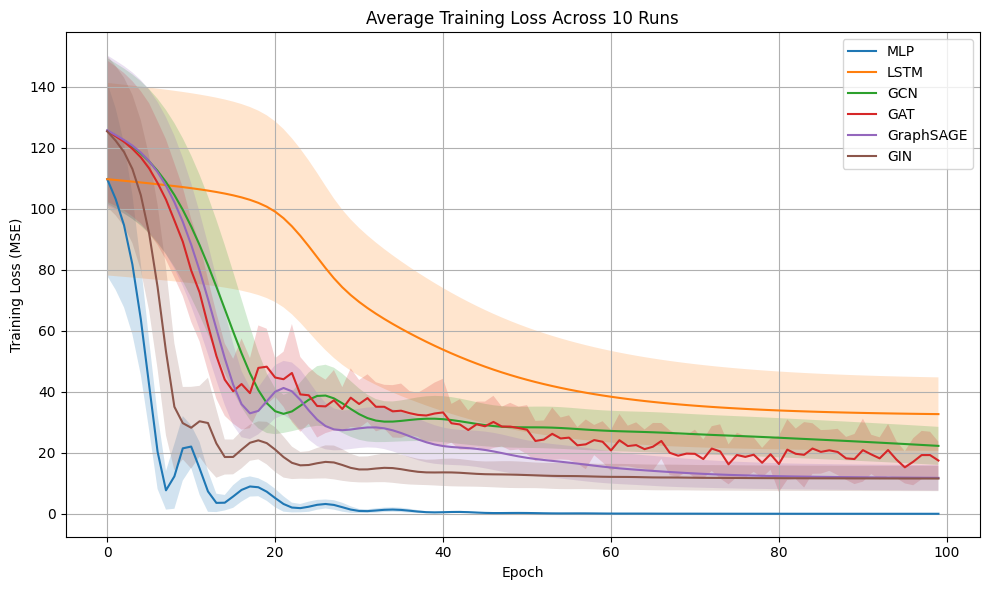

In [12]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)
    epochs = np.arange(len(mean_loss))
    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_qaoa_dataset.png", dpi=300)
plt.show()

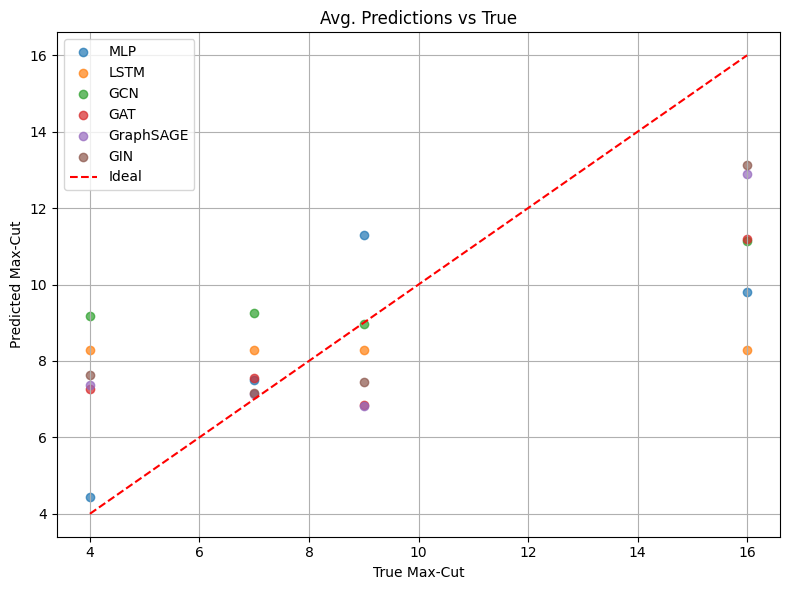

In [13]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_qaoa_dataset.png", dpi=300)
plt.show()


In [14]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs ---\n")

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    true_vals = np.array(all_trues)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:  {mse:.4f}")
    results_lines.append(f"  MAE:  {mae:.4f}")
    results_lines.append(f"  Approx Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

output_path = "results_qaoa_dataset.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Results saved to {output_path}")


✅ Results saved to results_qaoa_dataset.txt


## Random graphs only

In [15]:
def generate_dual_formulation_dataset(n_samples=300, n_min=4, n_max=16, test_ratio=0.2):
    data_vec, data_pyg = [], []

    for _ in range(n_samples):
        n = np.random.randint(n_min, n_max + 1)
        q = np.random.randn(n, n)
    
        q_sym = 0.5 * (q + q.T)
        sigma = np.random.choice([-1, 1], size=n)
        abs_q = np.abs(q_sym)
        lambda_vec = abs_q.sum(axis=1)
        lambda_diag = np.diag(lambda_vec)
        b = (q_sym + lambda_diag) @ sigma
        A = (q_sym / 4).copy()
        np.fill_diagonal(A, 0) 
        A[np.abs(A) < 1e-2] = 0
        G = nx.from_numpy_array(A)
        if len(G.edges) == 0:
            continue 
        for u, v in G.edges():
            G[u][v]['weight'] = A[u, v]
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=n_max))

    return train_test_split(data_pyg, test_size=test_ratio), train_test_split(data_vec, test_size=test_ratio)


In [16]:
all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

for run in range(runs):
    print(f"\n--- Seeded Run {run+1} ---")
    set_seed(run)
    (pyg_train, pyg_test), (vec_train, vec_test) = generate_dual_formulation_dataset()
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    mlp = MaxCutMLP(input_size=X_train.shape[1])
    preds, true, losses = train_vec(mlp, X_train, y_train, X_test, y_test)
    all_losses["MLP"].append(losses)
    all_preds["MLP"].append(preds)
    if run == 0:
        all_trues = true
    
    lstm_model = MaxCutLSTM(input_dim=X_train.shape[1])
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    lstm_model.train()
    lstm_losses = []
    for epoch in range(100):
        total_loss = 0
        for i in range(0, len(X_train), 32):
            xb = torch.tensor(X_train[i:i+32])
            yb = torch.tensor(y_train[i:i+32])
            preds = lstm_model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        lstm_losses.append(total_loss / (len(X_train) // 32 + 1))
    lstm_model.eval()
    all_preds_run = []
    with torch.no_grad():
        for i in range(0, len(X_test), 32):
            xb = torch.tensor(X_test[i:i+32])
            preds = lstm_model(xb)
            all_preds_run.extend(preds.numpy())
    all_preds["LSTM"].append(all_preds_run)
    all_losses["LSTM"].append(lstm_losses)
    
    for Model, name in [(MaxCutGCN, "GCN"),(MaxCutGAT, "GAT"),(MaxCutGraphSAGE, "GraphSAGE"),(MaxCutGIN, "GIN")]:
        model = Model(input_dim=pyg_train[0].x.shape[1], hidden_dim=32)
        preds, _, losses = train_gnn(model, pyg_train, pyg_test)
        all_losses[name].append(losses)
        all_preds[name].append(preds)


--- Seeded Run 1 ---
[MLP] Epoch 1, Loss: 41.8727
[MLP] Epoch 2, Loss: 40.6678
[MLP] Epoch 3, Loss: 39.2640
[MLP] Epoch 4, Loss: 37.4409
[MLP] Epoch 5, Loss: 34.9685
[MLP] Epoch 6, Loss: 31.6521
[MLP] Epoch 7, Loss: 27.4190
[MLP] Epoch 8, Loss: 22.3268
[MLP] Epoch 9, Loss: 16.6324
[MLP] Epoch 10, Loss: 10.9269
[MLP] Epoch 11, Loss: 6.2968
[MLP] Epoch 12, Loss: 4.3247
[MLP] Epoch 13, Loss: 6.0480
[MLP] Epoch 14, Loss: 8.9004
[MLP] Epoch 15, Loss: 9.3345
[MLP] Epoch 16, Loss: 7.4710
[MLP] Epoch 17, Loss: 4.9270
[MLP] Epoch 18, Loss: 2.9368
[MLP] Epoch 19, Loss: 1.9478
[MLP] Epoch 20, Loss: 1.8187
[MLP] Epoch 21, Loss: 2.1692
[MLP] Epoch 22, Loss: 2.6339
[MLP] Epoch 23, Loss: 2.9712
[MLP] Epoch 24, Loss: 3.0614
[MLP] Epoch 25, Loss: 2.8873
[MLP] Epoch 26, Loss: 2.4988
[MLP] Epoch 27, Loss: 1.9904
[MLP] Epoch 28, Loss: 1.4813
[MLP] Epoch 29, Loss: 1.0887
[MLP] Epoch 30, Loss: 0.8943
[MLP] Epoch 31, Loss: 0.9060
[MLP] Epoch 32, Loss: 1.0426
[MLP] Epoch 33, Loss: 1.1684
[MLP] Epoch 34, Loss

/var/folders/fn/b9jm0kpj3k51rtzysg66fpnr0000gn/T/ipykernel_20257/1859381195.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_train[i:i+32])
/var/folders/fn/b9jm0kpj3k51rtzysg66fpnr0000gn/T/ipykernel_20257/1859381195.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yb = torch.tensor(y_train[i:i+32])
/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.redu

[MaxCutGCN] Epoch 1, Loss: 34.2610
[MaxCutGCN] Epoch 2, Loss: 18.8442
[MaxCutGCN] Epoch 3, Loss: 10.2831
[MaxCutGCN] Epoch 4, Loss: 8.9571
[MaxCutGCN] Epoch 5, Loss: 8.4215
[MaxCutGCN] Epoch 6, Loss: 7.4247
[MaxCutGCN] Epoch 7, Loss: 6.5888
[MaxCutGCN] Epoch 8, Loss: 6.2330
[MaxCutGCN] Epoch 9, Loss: 5.3267
[MaxCutGCN] Epoch 10, Loss: 4.6084
[MaxCutGCN] Epoch 11, Loss: 3.6317
[MaxCutGCN] Epoch 12, Loss: 2.8853
[MaxCutGCN] Epoch 13, Loss: 2.1609
[MaxCutGCN] Epoch 14, Loss: 1.5101
[MaxCutGCN] Epoch 15, Loss: 0.9686
[MaxCutGCN] Epoch 16, Loss: 0.7307
[MaxCutGCN] Epoch 17, Loss: 0.5048
[MaxCutGCN] Epoch 18, Loss: 0.4463
[MaxCutGCN] Epoch 19, Loss: 0.4860
[MaxCutGCN] Epoch 20, Loss: 0.4740
[MaxCutGCN] Epoch 21, Loss: 0.4386
[MaxCutGCN] Epoch 22, Loss: 0.5044
[MaxCutGCN] Epoch 23, Loss: 0.4138
[MaxCutGCN] Epoch 24, Loss: 0.4007
[MaxCutGCN] Epoch 25, Loss: 0.3883
[MaxCutGCN] Epoch 26, Loss: 0.3933
[MaxCutGCN] Epoch 27, Loss: 0.3794
[MaxCutGCN] Epoch 28, Loss: 0.3790
[MaxCutGCN] Epoch 29, Loss

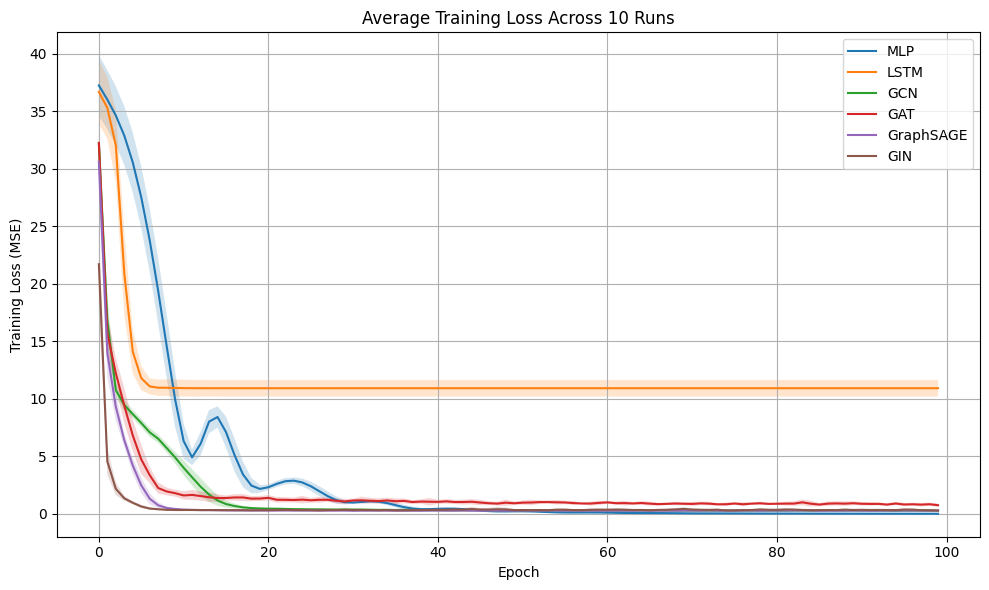

In [17]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)

    epochs = np.arange(len(mean_loss))
    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_er_dataset.png", dpi=300)
plt.show()

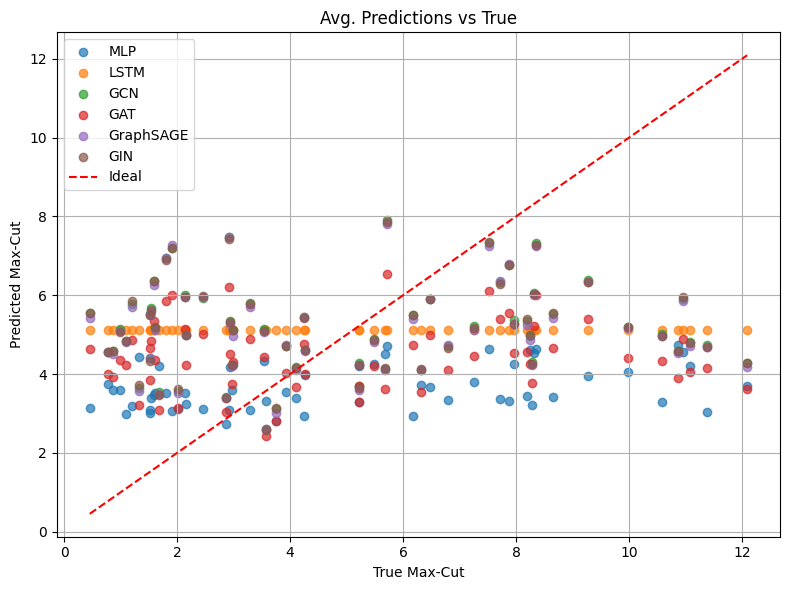

In [18]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_er_dataset.png", dpi=300)
plt.show()


In [19]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs ---\n")

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    true_vals = np.array(all_trues)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:  {mse:.4f}")
    results_lines.append(f"  MAE:  {mae:.4f}")
    results_lines.append(f"  Approx Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

output_path = "results_er_dataset.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Results saved to {output_path}")


✅ Results saved to results_er_dataset.txt
